# LinDHA Mk 4 (LASSO)

In this notebook, we automate the feature search process usin regularization.

Specifically, rather than try to engineer and test different bundles of features by hand, we'll automate the process somewhat using LASSO.
- LASSO adds an $L_1$-penalty term for each coefficient in the cost function. This additional contraint will generally force the model to find an optimal solution where unimportant coefficients will be set to 0 and highly corralated coefficients are purge in favor of a single respresentative.
- In short, LASSO throws away unimportant and redundant features. This reduces the dimensionality and tames a lot of the overfitting coming from having too many features.

The basic idea is to overload the model's capacity using an absurdly large amount of polynomial features, and let the model use LASSO to decide which features are the most cost-effective to keep and which features to drop. 

Since we plan on increasing the number of features (into the 30,000+ range!), the dataframes will also grow obscenely large. Unfortunately our ```Project``` class was not optimized to deal with data structures this huge (since it stores multiple redundant copies of the same dataframe for version control purposes). As such we'll have to abandon using it from here on out (at least until the we can successfully optimize class and how the data is stored).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV


from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

import joblib

import PaulBettany as jarvis


pd.options.display.max_columns = 100
pd.options.display.max_rows = 2000


seed=1

## 4.1 The Overfitting Problem

In [2]:
# read in data

train = pd.read_csv('../data/train.csv', index_col = 'Id')
data = pd.read_csv('../data/ames-cleaned.csv', index_col = 'Id').drop(columns='SalePrice')

# set up some useful variables
y = train['SalePrice']

m = len(train.index)

# cast MS SubClass as a categorical variable.
data['MS SubClass'] = data['MS SubClass'].astype('object')

In [3]:
# one-hot encoding of categoricals
data_dummies = pd.get_dummies(data, drop_first=True)

C:\Users\herma\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [4]:
data_dummies.shape

(2929, 275)

- We notice 2929 rows and 275 columns (the large number of rows is because the unlabeled Kaggle data is attached to the training set). We slice them out now to extract the training set we desire.

In [5]:
# slice labeled data from unlabeled data (i.e. the kaggle set)
X = data_dummies[ : m ]
Xkaggle = data_dummies[ m : ]

In [6]:
X.shape

(2051, 275)


- With 275 columns, it is not feasible to check all possible combinations of features by hand. We could just try to use all the features and we will do so now to illustrate the point of LASSO.

In [7]:
# build a mock LinearRegression() model to see the overfitting problem
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)

prototype = LinearRegression()

print(cross_val_score(prototype, X_train, y_train))

prototype.fit(X_train, y_train)

jarvis.grade_model(prototype, X_train, y_train, display=True), jarvis.grade_model(prototype, X_test, y_test, display=True);


[0.7587761  0.70624897 0.22206393 0.80977173 0.15181886]
 
R2 :0.946817362858933
MSE: 324669595.78350323
RMSE: 18018.590282913457
MAE: 12458.02164184778
 
 
R2 :0.8760927124233077
MSE: 863439531.4163644
RMSE: 29384.34160256725
MAE: 17522.113549197216
 


- It is quite clear that the model is overfitting from having 275 features. We would like to either drop some of the useless features or at least replace them with more useful ones. 


## 4.2 All Features on the Table

What we will do is engineer all the polynomial features at once and then systematically eliminate the useless ones until we get a model we like.

**Warning:** we will call the ```PolynomialFeatures()``` class from ```sklearn``` directly on to the dataframe we currently have. *This is bad practice* because the dataframe we currently have contains dummy variables. What this means: if we try to fit our polynomial transformer onto this data set, *we get polynomial terms for the dummy variables*. This is not good practice because:
- a lot of these dummy polynomial terms will be all 0's if they are interactions between 2 mutually exclusive classes. This eats up memory and processing time for what is essentially an empty column of 0's.
- square terms of dummy columns are just the same as the original columns. This quite literally produces a cloned/duplicate copy of the dummy column which again eats up memory and processing time.

With that being said, LASSO actually can throw away all these useless and duplicate columns, so we go ahead and proceed anyways, but it is generally not recommended for us to do so on other models (e.g. Ridge!). The point is that fitting the polynomial transform onto our data set will give us the interaction/cross-terms between categories, e.g. ```Exter Qual_Ex * Exter Cond_Ex```, which is what we want.

In [8]:
# get polynomial features
poly = PolynomialFeatures(degree=2, # This is the default setting but we explicitly state it here for clarity
                          include_bias=False)

data_poly = pd.DataFrame(poly.fit_transform(data_dummies), index=data_dummies.index, columns=poly.get_feature_names_out(data_dummies.columns))

X_poly = data_poly[ : m ]
Xkaggle = data_poly[ m : ]

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=seed)

In [9]:
X_poly.shape

(2051, 38225)

- We now have 38,225 features. That is over $ 2^{38,000} $ possible combinations of features to check.
- For reference: even if we could check 6,000 combinations per second, it would still take us over **20-times the life span of the universe** to run through all the possibilities.

## 4.3 Feature Selection with LASSO

We saw previous that it was not possible to try every combination of features by hand. This is where LASSO saves the day for us. The idea behind LASSO is to augment the augment the cost function by adding an $L_1$-penalty term:
$$ \min_{\beta} \frac{1}{m}\sum_{i=1}^{m}\left( y^{(i)}-h_{\beta}(x^{(i)})\right)^2 + \alpha\sum_{i=1}^{n}\left| \beta_i \right| $$
where we use $h_{\beta}(x)$ to denote the linear model $h_{\beta}(x) = \beta_0+\beta_1x_1+\ldots+\beta_nx_n$. Because of the nature of the $L_1$-norm, the constraint region is a square and the optimal solution will almost always occur at the vertex of the square. Because of this fact, LASSO is able to a lot of the $\beta$ components equal to 0 as it optimizes via gradient descent. 

The net effect: the model discards a lot of the useless features and only keeps features that are deemed cost-effective. The idea then is to **purposefully overload the model's capacity** for overfitting and slowly reel it back in via LASSO.
- We can control how many parameters to keep or discard by tuning the hyperparameter $\alpha$. Larger $\alpha$ = higher penalty, so more features are discarded.

In [10]:
# instantiate LASSO model
lindhamk4_1 = Lasso(alpha=100, # alpha = 100 because we have 38,000+ featuers and need to almost all of them
                    max_iter = 10_000
                   ) 

- LASSO trains via gradient descent, so we need to scale the features or the descent might not be stable.

In [11]:
# instantiate StandardScaler
zscale = StandardScaler()

# fit to X_train and transform inputs
Xs_train = zscale.fit_transform(X_train)
Xs_test = zscale.transform(X_test)
Xs_kaggle = zscale.transform(Xkaggle)

In [12]:
# Here we fit the model. Training will take a nontrivial amount of time
# so we comment out the code and load in a pre-trained model for the reader to use

######################## Mirror Dimension ###########################
# 
# lindhamk4_1.fit(Xs_train, y_train)
# 
# joblib.dump(lindhamk4_1, '../saved-files/lindhamk4_1.pkl')
#
#########################################################

lindhamk4_1 = joblib.load('../saved-files/lindhamk4_1.pkl')

In [13]:
jarvis.grade_model(lindhamk4_1, Xs_train, y_train, display=True);
jarvis.grade_model(lindhamk4_1, Xs_test, y_test, display=True);

 
R2 :0.9929548448891432
MSE: 43009293.7288303
RMSE: 6558.147126195805
MAE: 4312.618491787207
 
 
R2 :0.9048017883463115
MSE: 663382282.5881834
RMSE: 25756.208622159113
MAE: 16393.370162816835
 


In [14]:
# Let's take a look at how many features Lasso decided to use:
jarvis.support(lindhamk4_1)

1553

- Our model decided to use 1553 features; this is causing some significant overfitting. 
- We can tame the overfitting by increasing the size of $\alpha$, thereby forcing the model to use less features.
- However, manually testing each individual $\alpha$ is quite laborious. Since we've already automated the feature selection, we might as well automate the hyper parameter tuning via a **Grid Search**.

<br> 

## 4.4 Grid Search

The idea of the Grid Search is very simple: just run through an exhaustive list of hyperparameters and return the hyperparameter with the best results.

In [15]:
# set up inputs for grid search
model = Lasso()
params = { 'alpha' : list( range(400,800,20) ) }

In [16]:
# instantiate the GridSearchCV object
lindhamk4_2 = GridSearchCV( model , # model to grade
                             params, # paramters to try
                             n_jobs=-1, # number of cpu-cores to use
                             scoring = 'neg_root_mean_squared_error' # what metric to grade on
                                                                     # NOTE: GridSearchCV actually does gradient ascent so it maximizes
                                                                     # functions, hence the error scores must be negated.
                           )

In [17]:
# Run grid search over all the listed values of alpha.
# we have locked away the code for the GridSearchCV because
# it takes a while to run. Instead the pre-searched model is
# loaded from a save file.


####################### Mirror Dimension ############################
#
# lindhamk4_2.fit(Xs_train, y_train)
#
# cross_val_score(Lasso(alpha=640), Xs_train, y_train, n_jobs=-1)
#
# joblib.dump(lindhamk4_2, '../saved-files/lindhamk4_2.pkl')
#
##############################################################



# load pre-trained model so we don't have to keep re-searching
# every time we restart the notebook!
lindhamk4_2 = joblib.load('../saved-files/lindhamk4_2.pkl')

In [18]:
lindhamk4_2.best_estimator_

Lasso(alpha=640)

In [19]:
jarvis.grade_model(lindhamk4_2, Xs_train, y_train, display=True), jarvis.grade_model(lindhamk4_2, Xs_test, y_test, display=True);

 
R2 :0.9691250350519321
MSE: 188485621.02947116
RMSE: 13729.006556538283
MAE: 9831.647438565225
 
 
R2 :0.9183782763399494
MSE: 568775446.6161594
RMSE: 23849.013535493654
MAE: 14302.880990217034
 


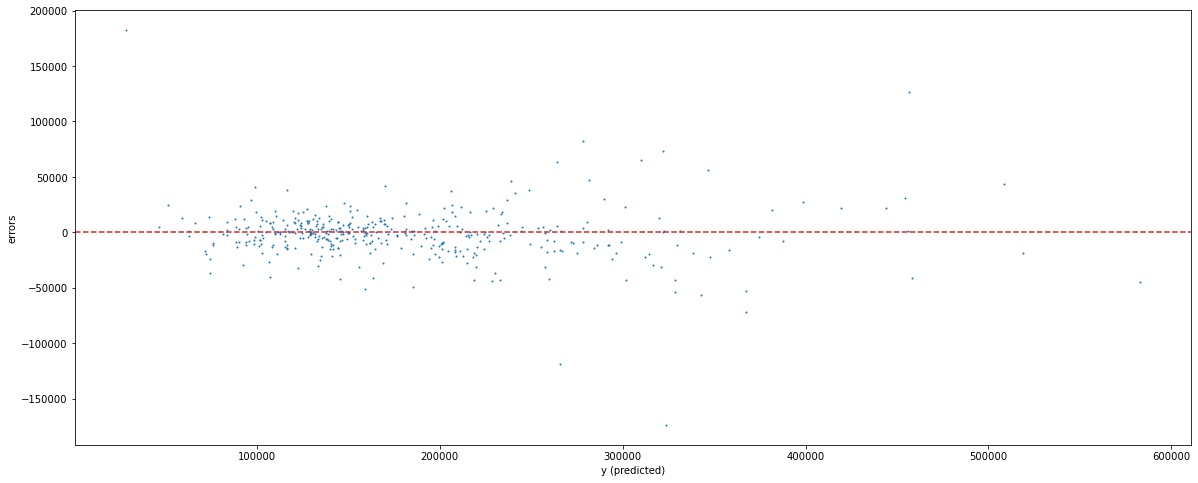

In [20]:
jarvis.plot_residuals(lindhamk4_2, Xs_test, y_test)

# 4.5 More Tuning

It seems the model isn't as good as the Mk 3 model where we engineered features by hand. Let's try running LASSO on the Mk 3's training set to see if we can improve it.

In [21]:
# drop outlier value
train.drop(index=2181, inplace=True)
y = train['SalePrice']

# use engineered features from Mk 3
data = pd.read_csv('../data/ames-engineered.csv', index_col='Id').drop(columns = ['SalePrice', '1st Flr SF', '2nd Flr SF'] )

data.shape

(2928, 97)

In [22]:
# locate the sqrt features and slice them out
data.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Ga

In [23]:
data = data.iloc[:, :90]

In [24]:
data.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Ga

In [25]:
data['MS SubClass'] = data['MS SubClass'].astype('object')

# prepare data set
data_dummies = pd.get_dummies(data, drop_first=True)

C:\Users\herma\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [26]:
data_poly = pd.DataFrame(poly.fit_transform(data_dummies), index=data_dummies.index, columns=poly.get_feature_names_out(data_dummies.columns))


X_poly = data_poly[ : m-1 ]
Xkaggle = data_poly[ m-1 : ]

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=seed)

In [27]:
# scale data
Xs_train = zscale.fit_transform(X_train)
Xs_test = zscale.transform(X_test)
Xs_kaggle = zscale.transform(Xkaggle)

In [28]:
# check out the shape of our training set
Xs_train.shape

(1640, 42194)

In [29]:
# create parameter "grid" for grid search
params = { 'alpha' : list( range(600, 2000, 20) ) }

In [30]:
lindhamk4_3 = GridSearchCV( 
                            estimator = Lasso(max_iter=10_000),
                            param_grid = params, 
                            n_jobs=-1,
                            scoring = 'neg_root_mean_squared_error',
                            verbose=2,
                        )
                  

In [31]:
##################### Mirror Dimension ################################
#
# lindhamk4_3.fit(Xs_train, y_train)
#
# joblib.dump(lindhamk4_3, '../saved-files/lindhamk4_3.pkl')
#
##################################################################

lindhamk4_3 = joblib.load('../saved-files/lindhamk4_3.pkl')

In [32]:
lindhamk4_3.best_estimator_

Lasso(alpha=800, max_iter=10000)

In [33]:
jarvis.grade_model(lindhamk4_3, Xs_train, y_train, display=True), jarvis.grade_model(lindhamk4_3, Xs_test, y_test, display=True);

 
R2 :0.9662245642352453
MSE: 210182932.46172053
RMSE: 14497.687141807155
MAE: 10626.060975272812
 
 
R2 :0.917343917758283
MSE: 538594182.1954808
RMSE: 23207.631981645194
MAE: 13761.633337612042
 


In [34]:
# Try searching a different set of parameters
params2 = { 'alpha' : list( range(600, 650, 10) ) }

In [35]:
lindhamk4_4 = GridSearchCV( 
                            estimator = Lasso(max_iter=10_000),
                            param_grid = params2, 
                            n_jobs=-1,
                            scoring = 'neg_root_mean_squared_error',
                            verbose=2,
                            cv=5
                        )

In [36]:
######################### Mirror Dimension #############################
#
#lindhamk4_4.fit(Xs_train, y_train)
#
#joblib.dump(lindhamk4_4, '../saved-files/lindhamk4_4.pkl')
#
#############################################################


lindhamk4_4=joblib.load('../saved-files/lindhamk4_4.pkl')

In [37]:
lindhamk4_4.best_estimator_

Lasso(alpha=640, max_iter=10000)

In [38]:
jarvis.grade_model(lindhamk4_4, Xs_train, y_train, display=True), jarvis.grade_model(lindhamk4_4, Xs_test, y_test, display=True);

 
R2 :0.9713334309251276
MSE: 178390697.7170845
RMSE: 13356.29805436688
MAE: 9812.04357189086
 
 
R2 :0.9183248362733244
MSE: 532202432.2954051
RMSE: 23069.513048510693
MAE: 13565.74838246168
 


In [39]:
jarvis.support(lindhamk4_4.best_estimator_)

492

In [40]:
# save features
# this takes awhile because the dataframe is gigantic :(

# data_poly.to_csv('../data/ames-poly-engineered.csv')

Seems we've reached an asymptotic point with LASSO. On the one hand, we optimized it for RMSE and not R2-score. On the other hand the R2 score is still respectable.

One caveat about LASSO: it generally tends to underfit because it will always pick only one feature out of a multi-collinear set of features. Thus, it might be the case that the LASSO model is throwing away features that are not cost-efficient but provide the granular detail it needs to make more accurate predictions.

There is an solution to this possible problem: Ridge (which we explore in the next notebook).

In [ ]:
lindhamk4_final = Lasso(alpha=600, max_iter=10_000)

lindhamk4_final.fit(Xs_train, y_train)

In [ ]:
# check number of non-zero features
jarvis.support(lindhamk4_final)

In [ ]:
# prepare kaggle submissions
submissions = pd.read_csv('../data/test.csv', index_col='Id')


In [ ]:
submissions['SalePrice']=lindhamk4_final.predict(Xs_kaggle)

In [ ]:
submissions[['SalePrice']].to_csv('../data/lindhamk4-submissions.csv')